# Time Series - Arima PETR4

Nesse código vamos fazer uso de séries temporais para prever os preços da ação PETR4.
Definição de Série Temporal: é uma sequência de dados ao longo do tempo, onde as observações são capturadas em espaços de tempo regulares.
A principal motivação de usar séries temporais é para entender o processo gerador de determinado dado e também para "desenhar" um modelo que seja capaz de monitorar e fazer previsões sobre este processo.
É importante frisar que uma série temporal possui três componentes: Tendência, sazonalidade e resíduo. A tendência diz respeito a direção de longo prazo da séries, a sazonalidade são as oscilações periodicas devido a carecterística temporal da série e o resíduo são as flutuações irregulares e aleatórias. 

In [112]:
# Importando bibliotecas (obs: datetime para pegar dados em sites)
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
import pyflux as pf

ModuleNotFoundError: No module named 'pyflux'

In [113]:
# Importando ARIMA 
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf


In [114]:
# Especificando o período da série histórica
start = dt.datetime(2015,1,1)
end = dt.datetime(2020,6,30)

In [115]:
# Importando dados do yahoo finance
petr4 = web.DataReader("PETR4.SA", "yahoo", start, end)

In [116]:
# DataFrame com os preços de: Máximo, Mínimo, Abertura, Fechamento, Volume e Preço Ajustado
petr4

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,9.990000,9.350000,9.990000,9.360000,49559500.0,8.683293
2015-01-05,9.190000,8.530000,9.140000,8.560000,78385100.0,7.941135
2015-01-06,8.830000,8.040000,8.710000,8.280000,84723300.0,7.681378
2015-01-07,8.730000,8.360000,8.560000,8.670000,85531000.0,8.043181
2015-01-08,9.390000,8.740000,8.790000,9.230000,83306300.0,8.562695
...,...,...,...,...,...,...
2020-06-24,21.559999,20.709999,21.490000,21.000000,65162400.0,20.999582
2020-06-25,21.469999,20.730000,20.910000,21.469999,47263500.0,21.469574
2020-06-26,21.469999,20.780001,21.209999,20.840000,55499300.0,20.839586


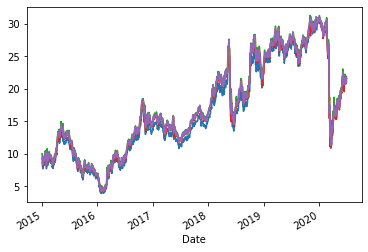

In [117]:
# Gráficos dos preços coletados

petr4["Adj Close"].plot()
petr4["Open"].plot()
petr4["High"].plot()
petr4["Low"].plot()
petr4["Close"].plot()

In [118]:
# Definindo a base a partir do preço de fechamento
petr4_close = petr4["Close"]

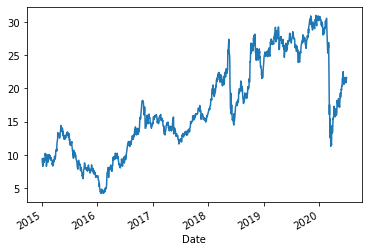

In [119]:
# Visualizando a série inteira
petr4_close.plot()

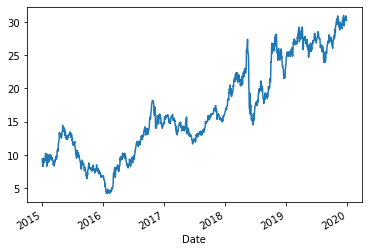

In [120]:
# Separando dados para o treino e visualizando
petr4_treino = petr4_close["2015-01-01":"2020-01-01"]
petr4_treino.plot()

In [121]:
# Existe NaNs nos dados?
print(petr4_close.isnull().values.any().sum())

0


In [122]:
# Conhecendo nossa base inteira - estatística descritiva
petr4_close.describe()

count    1363.000000
mean       17.118944
std         7.124282
min         4.200000
25%        11.920000
50%        15.670000
75%        23.959999
max        30.969999
Name: Close, dtype: float64

In [123]:
# Conhecendo os dados de treino - estatística descritiva
petr4_treino.describe()

count    1241.000000
mean       16.663739
std         7.066000
min         4.200000
25%        10.930000
50%        15.310000
75%        22.820000
max        30.969999
Name: Close, dtype: float64

A princípio as estatísticas descritivas dos dois conjuntos (treino e série completa) são bem parecidas. Essa investigação é necessária para dar início ao processo de verificar se a série é estacionária, como preoconiza a teoria.
Uma série estacionária é um processo aleatório com média e variância constante. Saber se uma série é estacionária ou não é importante para calibrar o modelo que estamos "desenhando" para fazer previsões. A seguir vamos realizar teste de estacionariedade, Augmented Dicky Fuller.


In [124]:
# Teste de Estacionariedade para toda a série
def teste_estacionariedade(serie):
    # Estatisticas de rolamento (Rolling Statistics)
    rol_mean = serie.rolling(window=12).mean()
    rol_std = serie.rolling(window=12).std()
    plt.plot(serie, color='black',label='Original')
    plt.plot(rol_mean, color='red', label='Média')
    plt.plot(rol_std, color='blue', label='Desvio Padrão')
    plt.xlabel('Data')
    plt.ylabel("R$")
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    return [rol_mean.index,serie,rol_mean,rol_std]

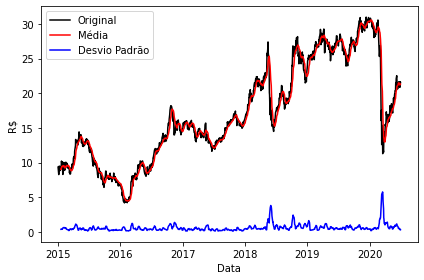

In [125]:
indice, serie, media_serie,std_serie = teste_estacionariedade(petr4_close)

In [126]:
# Comprovando com Teste de ADF e importando adfuller

from statsmodels.tsa.stattools import adfuller

print ('Results of Dickey-Fuller Test:')
dftest = adfuller(petr4_treino, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -0.699221
p-value                           0.846951
#Lags Used                        6.000000
Number of Observations Used    1234.000000
Critical Value (1%)              -3.435660
Critical Value (5%)              -2.863885
Critical Value (10%)             -2.568019
dtype: float64


O teste de ADF pressupõe que a série é não-estacionária.  H0: Não estacionária   H1: Estacionária
Caso o p-valor maior que 0.05, então a série é não estacionária. Como podemos perceber, a petr4_treino é não estacionário. 

Os próximos passos são realizados para tornar a série estacionária. Algumas técnincas a exemplo da diferenciação e transformação em log são úteis para tornar os dados estacionários. 

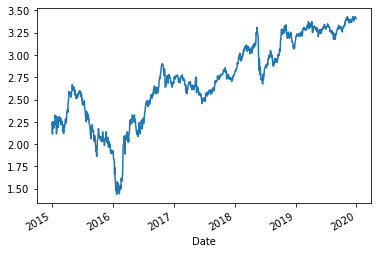

In [127]:
# Verificando se o log da série é estacionário
petr4_treino_log = np.log(petr4_treino)
petr4_treino_log.plot()

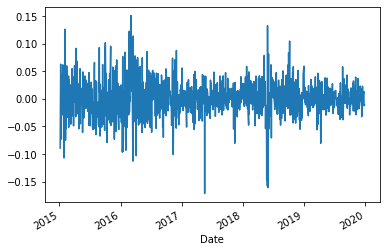

In [128]:
# Diferenciando a série log
petr4_treino_log_diff = petr4_treino_log - petr4_treino_log.shift()
petr4_treino_log_diff.plot()

O gráfico da série petr4_treino em log e diferenciado já mostra que a série não possui tendência e sazonalidade. Portanto é estacionária. Ainda, é preciso verificar se a série possui autocorrelação, algo muito comum de ocorrer em séries temporais. Para tanto, vamos plotar a ACF (autocorrelation function) e PACF (partial autocorrelation function). Em linhas gerais a ACF e PACF vão mostrar a autocorrelação presente entre os lags (ACF) e presente nos resíduos (PACF).

In [129]:
# Importanto acf e pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


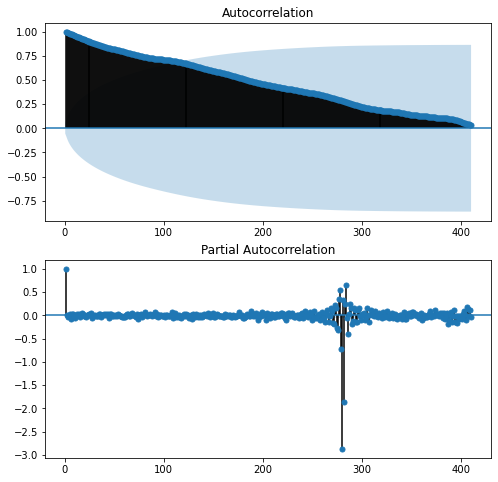

In [130]:
#Criando a figura para os dados de treino (sem tratamento)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

# ACF para os dados de treino 
plot_acf(petr4_treino, lags=410, zero=False, ax=ax1)

# PACF para os dados de treino 
plot_pacf(petr4_treino, lags=410, zero=False, ax=ax2)

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


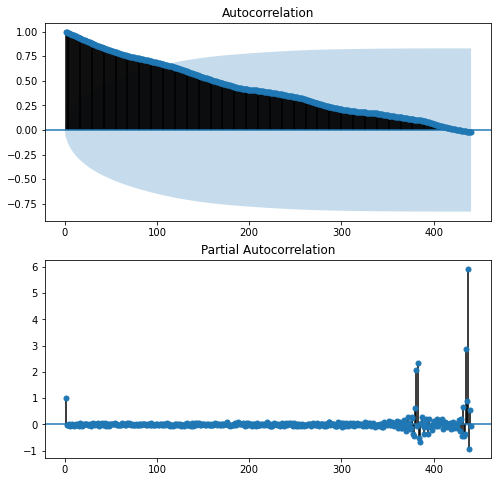

In [131]:
#Criando a figura para os dados em log
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8))

# ACF para os dados de treino log 
plot_acf(petr4_treino_log, lags=440,zero=False, ax=ax1)

# PACF para os dados de treino log 
plot_pacf(petr4_treino_log, lags=440,zero=False, ax=ax2)

plt.show()

ACF: indica autocorrelação entre os lags
PACF: autocorrelação dos resíduos estão dentro do intervalo aceitável e indicam que eles não estão autocorrelacionados.

 O Modelo Arima é uma técnica estatística muito utilizada na previsão de séries temporais. ARIMA quer dizer: modelo autorregressivo integrado de médias móveis. O AR é o componente autorregressivo da série, o I é o termo de diferenciação da variável no modelo e o MA é a ordem da média móvel. 
Os parâmetros que indicam a ordem do modelo ARIMA são conhecidos como p, q e d. O p são os lags do modelo (componente autorregressivo), o q é a ordem da média móvel e o d é a ordem de diferenciação. 

Os passos anteriores de verificação de raiz unitária pelo teste de ADF, a função de ACF e PACF determinam as ordens do modelo ARIMA, justamente por isso é importante essa investigação antes de estimar e prever valores.

In [132]:
#  Instalando e Descobrindo o modelo ARIMA com o auto_arima
!pip install pmdarima
from pmdarima.arima import auto_arima



In [133]:
#Identificando o modelo ARIMA 
model = auto_arima(petr4_treino, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(petr4_treino)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1641.492, Time=4.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1648.515, Time=0.36 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1646.941, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1647.007, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1648.099, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1648.265, Time=1.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1648.717, Time=2.00 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1644.488, Time=3.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1644.938, Time=3.52 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1648.929, Time=0.81 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1644.152, Time=1.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1649.760, Time=0.56 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1644.643, Time=4.90 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1641.080, Time=0.93 sec
 ARIMA(1,1,2)(0,0,0)[0]          

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

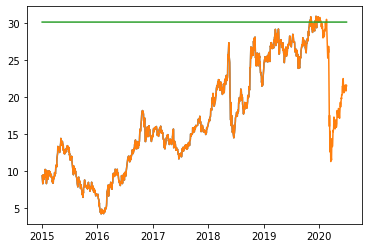

In [139]:
forecast = model.predict(n_periods=len(petr4_close))
forecast = pd.DataFrame(forecast,index = petr4_close.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(petr4_treino, label='petr4_treino')
plt.plot(petr4_close, label='petr4_close')
plt.plot(forecast, label='Prediction')
plt.show()

ARIMA(order=(0, 1, 0), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)